In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('transacciones_procesadas.csv')
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Address Match,Day,Day of the week,Month
0,42.32,PayPal,electronics,1,40,desktop,False,282,23,True,24,6,3
1,301.34,credit card,electronics,3,35,tablet,False,223,0,True,22,0,1
2,340.32,debit card,toys & games,5,29,desktop,False,360,8,False,22,0,1
3,95.77,credit card,electronics,5,45,mobile,False,325,20,True,16,1,1
4,77.45,credit card,clothing,5,42,desktop,False,116,15,True,16,1,1


In [2]:
df_2 = df.copy()

# 1.Preprocesamiento

Tras el primer pre-procesamiento se tienen algunas columnas sobre las cuales ya podríamos aplicar reglas de asociación, por ejemplo:

*   Payment Method → 4 métodos
* Product Category → 5 categorías
* Device Used → 3 dispositivos
* Is Fraudulent → (0 o 1)

Lo primero que haremos será discretizar las variables numéricas.


| Columna              | Propuesta de discretización                                  |
| -------------------- | ------------------------------------------------------------ |
| `Transaction Amount` | Bajo, Medio, Alto, Muy alto (por percentiles)                |
| `Quantity`           | 1, 2-3, >3                                                   |
| `Customer Age`       | Joven (14-30), Adulto (31-50), Mayor (>50)                   |
| `Account Age Days`   | Nuevo (0-90), Intermedio (91-270), Antiguo (>270)            |
| `Transaction Hour`   | Madrugada (0-5), Mañana (6-11), Tarde (12-17), Noche (18-23) |
| `Day of the week`    | Categoría textual: lunes, martes, ..., domingo               |
| `Month`              | Literal o estaciones (opcional según contexto)               |


In [3]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Transaction Amount,23634.0,NaN,NaN,NaN,229.367099,282.046669,10.0,69.07,151.415,296.1275,9716.5
Payment Method,23634,4,debit card,5952,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product Category,23634,5,home & garden,4786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,23634.0,NaN,NaN,NaN,3.00055,1.419663,1.0,2.0,3.0,4.0,5.0
Customer Age,23634.0,NaN,NaN,NaN,35.020437,9.414783,14.0,28.0,35.0,41.0,73.0
Device Used,23634,3,desktop,7923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Is Fraudulent,23634,2,False,22412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Account Age Days,23634.0,NaN,NaN,NaN,178.660531,107.388682,1.0,84.0,178.0,272.0,365.0
Transaction Hour,23634.0,NaN,NaN,NaN,11.266015,6.980659,0.0,5.0,11.0,17.0,23.0
Address Match,23634,2,True,21292,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.1 Transaction amount

 Vamos a discretizar la variable Transaction Amount en 4 rangos basados en sus percentiles, usando las etiquetas  'Bajo', 'Medio', 'Alto' y 'Muy Alto'. Para esto, utilizaremos los cuartiles 25, 50 y 75%.

In [4]:
percentiles = np.percentile(df['Transaction Amount'], [25, 50, 75])
bins = [df['Transaction Amount'].min()] + list(percentiles) + [df['Transaction Amount'].max()]
labels = ['Amount=Bajo', 'Amount=Medio', 'Amount=Alto', 'Amount=Muy Alto']

# Aplicar corte
df['Transaction Amount Binned'] = pd.cut(df['Transaction Amount'], bins=bins, labels=labels, include_lowest=True)
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Address Match,Day,Day of the week,Month,Transaction Amount Binned
0,42.32,PayPal,electronics,1,40,desktop,False,282,23,True,24,6,3,Amount=Bajo
1,301.34,credit card,electronics,3,35,tablet,False,223,0,True,22,0,1,Amount=Muy Alto
2,340.32,debit card,toys & games,5,29,desktop,False,360,8,False,22,0,1,Amount=Muy Alto
3,95.77,credit card,electronics,5,45,mobile,False,325,20,True,16,1,1,Amount=Medio
4,77.45,credit card,clothing,5,42,desktop,False,116,15,True,16,1,1,Amount=Medio


In [5]:
df[df['Is Fraudulent'] == True]['Transaction Amount Binned'].value_counts().sort_index()

,count
Transaction Amount Binned,
Amount=Bajo,181
Amount=Medio,247
Amount=Alto,245
Amount=Muy Alto,549


## 1.2. Customer Age

Para esta variable utilizaremos las escalas propuestas por el Ministerio de Salud de Colombia.

| Categoría    | Rango de edad | Etiqueta            |
| ------------ | ------------- | ------------------- |
| Adolescente  | 12–17         | `'Age=Adolescente'` |
| Joven        | 18–24         | `'Age=Joven'`       |
| Adulto       | 25–59         | `'Age=Adulto'`      |
| Adulto mayor | ≥60           | `'Age=Adulto Mayor'` |

No obstante, en lugar de 12, lo contaremos desde 14 (nuestro valor mínimo de edad).

In [6]:
bins_age = [14, 18, 25, 60, df['Customer Age'].max()] # Cortes
labels_age = ['Age=Adolescente', 'Age=Joven', 'Age=Adulto', 'Age=Adulto Mayor']
df['Customer Age Binned'] = pd.cut(df['Customer Age'], bins=bins_age, labels=labels_age, include_lowest=True)
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Address Match,Day,Day of the week,Month,Transaction Amount Binned,Customer Age Binned
0,42.32,PayPal,electronics,1,40,desktop,False,282,23,True,24,6,3,Amount=Bajo,Age=Adulto
1,301.34,credit card,electronics,3,35,tablet,False,223,0,True,22,0,1,Amount=Muy Alto,Age=Adulto
2,340.32,debit card,toys & games,5,29,desktop,False,360,8,False,22,0,1,Amount=Muy Alto,Age=Adulto
3,95.77,credit card,electronics,5,45,mobile,False,325,20,True,16,1,1,Amount=Medio,Age=Adulto
4,77.45,credit card,clothing,5,42,desktop,False,116,15,True,16,1,1,Amount=Medio,Age=Adulto


Como resultado, obtenemos 4 categorías para la edad, las cuales se concentran en diferentes proporciones.

In [7]:
df['Customer Age Binned'].value_counts()

,count
Customer Age Binned,
Age=Adulto,19676
Age=Joven,2962
Age=Adolescente,882
Age=Adulto Mayor,114


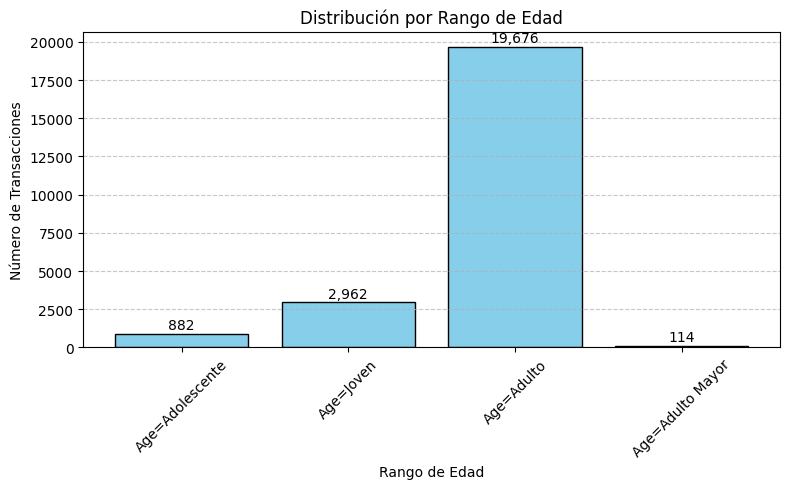

In [8]:
import matplotlib.pyplot as plt

# Contar valores por categoría
age_counts = df['Customer Age Binned'].value_counts().sort_index()

# Crear figura
plt.figure(figsize=(8, 5))
bars = plt.bar(age_counts.index, age_counts.values, color='skyblue', edgecolor='black')

# Añadir etiquetas encima de cada barra con separador de miles
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Etiquetas y formato
plt.title('Distribución por Rango de Edad')
plt.xlabel('Rango de Edad')
plt.ylabel('Número de Transacciones')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Dado que se presenta un desbalance considerable entre la categoría de adulto y las demás, vamos a segmentar la sección de 'Adulto' en dos: adulto joven de 25-39 y Adulto 40-59.

In [9]:
bins_age = [12, 18, 25, 40, 60, df['Customer Age'].max()]
labels_age = ['Age=Adolescente', 'Age=Joven', 'Age=AdultoJoven', 'Age=Adulto', 'Age=AdultoMayor']

df['Customer Age Binned'] = pd.cut(df['Customer Age'], bins=bins_age, labels=labels_age, include_lowest=True)
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Address Match,Day,Day of the week,Month,Transaction Amount Binned,Customer Age Binned
0,42.32,PayPal,electronics,1,40,desktop,False,282,23,True,24,6,3,Amount=Bajo,Age=AdultoJoven
1,301.34,credit card,electronics,3,35,tablet,False,223,0,True,22,0,1,Amount=Muy Alto,Age=AdultoJoven
2,340.32,debit card,toys & games,5,29,desktop,False,360,8,False,22,0,1,Amount=Muy Alto,Age=AdultoJoven
3,95.77,credit card,electronics,5,45,mobile,False,325,20,True,16,1,1,Amount=Medio,Age=Adulto
4,77.45,credit card,clothing,5,42,desktop,False,116,15,True,16,1,1,Amount=Medio,Age=Adulto


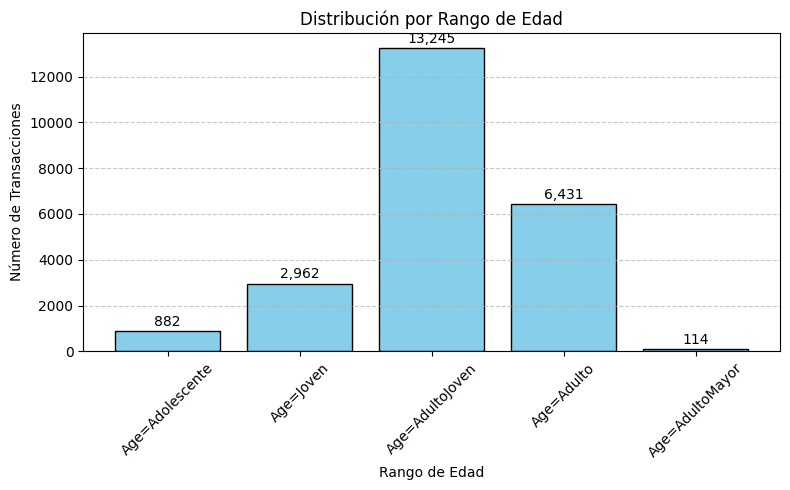

In [10]:
# Contar valores por categoría
age_counts = df['Customer Age Binned'].value_counts().sort_index()

# Crear figura
plt.figure(figsize=(8, 5))
bars = plt.bar(age_counts.index, age_counts.values, color='skyblue', edgecolor='black')

# Añadir etiquetas encima de cada barra con separador de miles
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Etiquetas y formato
plt.title('Distribución por Rango de Edad')
plt.xlabel('Rango de Edad')
plt.ylabel('Número de Transacciones')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Con esta nueva distribución quedará la variable 'Age' categorizada.

In [11]:
df[df['Is Fraudulent'] == True]['Customer Age Binned'].value_counts().sort_index()

,count
Customer Age Binned,
Age=Adolescente,37
Age=Joven,160
Age=AdultoJoven,670
Age=Adulto,349
Age=AdultoMayor,6


In [12]:
tabla = df.groupby('Customer Age Binned')['Is Fraudulent'].agg(['count', 'sum'])
tabla.rename(columns={'count': 'Total Transacciones', 'sum': 'Total Fraudes'}, inplace=True)
tabla['Porcentaje Fraude'] = (tabla['Total Fraudes'] / tabla['Total Transacciones']) * 100
tabla

/tmp/ipython-input-12-1450180908.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = df.groupby('Customer Age Binned')['Is Fraudulent'].agg(['count', 'sum'])


,Total Transacciones,Total Fraudes,Porcentaje Fraude
Customer Age Binned,,,
Age=Adolescente,882,37,4.195011
Age=Joven,2962,160,5.401756
Age=AdultoJoven,13245,670,5.058513
Age=Adulto,6431,349,5.426839
Age=AdultoMayor,114,6,5.263158


## 1.3. Account Age Days

Esta variable será categorizada en tres segmentos:

| Rango (días) | Etiqueta     |
| ------------ | -------------------- |
| 1 – 90       | `AccountAge=Nuevo`   |
| 91 – 180     | `AccountAge=Regular` |
| >180         | `AccountAge=Antiguo` |

Se considerará cliente nuevo a aquellos que lleven menos de un tres meses con la cuenta, regular a quienes lleven entre 3 y 6 meses y antiguo a aquellos con una edad de cuenta mayor a 6 meses.


In [13]:
bins_account = [0, 90, 180, df['Account Age Days'].max()]
labels_account = ['AccountAge=Nuevo', 'AccountAge=Regular', 'AccountAge=Antiguo']

df['Account Age Binned'] = pd.cut(df['Account Age Days'], bins=bins_account, labels=labels_account, include_lowest=True)
n_cols = 10
df.iloc[:, list(range(n_cols)) + list(range(-1, 0))].head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Address Match,Account Age Binned
0,42.32,PayPal,electronics,1,40,desktop,False,282,23,True,AccountAge=Antiguo
1,301.34,credit card,electronics,3,35,tablet,False,223,0,True,AccountAge=Antiguo
2,340.32,debit card,toys & games,5,29,desktop,False,360,8,False,AccountAge=Antiguo
3,95.77,credit card,electronics,5,45,mobile,False,325,20,True,AccountAge=Antiguo
4,77.45,credit card,clothing,5,42,desktop,False,116,15,True,AccountAge=Regular


In [14]:
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Address Match,Day,Day of the week,Month,Transaction Amount Binned,Customer Age Binned,Account Age Binned
0,42.32,PayPal,electronics,1,40,desktop,False,282,23,True,24,6,3,Amount=Bajo,Age=AdultoJoven,AccountAge=Antiguo
1,301.34,credit card,electronics,3,35,tablet,False,223,0,True,22,0,1,Amount=Muy Alto,Age=AdultoJoven,AccountAge=Antiguo
2,340.32,debit card,toys & games,5,29,desktop,False,360,8,False,22,0,1,Amount=Muy Alto,Age=AdultoJoven,AccountAge=Antiguo
3,95.77,credit card,electronics,5,45,mobile,False,325,20,True,16,1,1,Amount=Medio,Age=Adulto,AccountAge=Antiguo
4,77.45,credit card,clothing,5,42,desktop,False,116,15,True,16,1,1,Amount=Medio,Age=Adulto,AccountAge=Regular


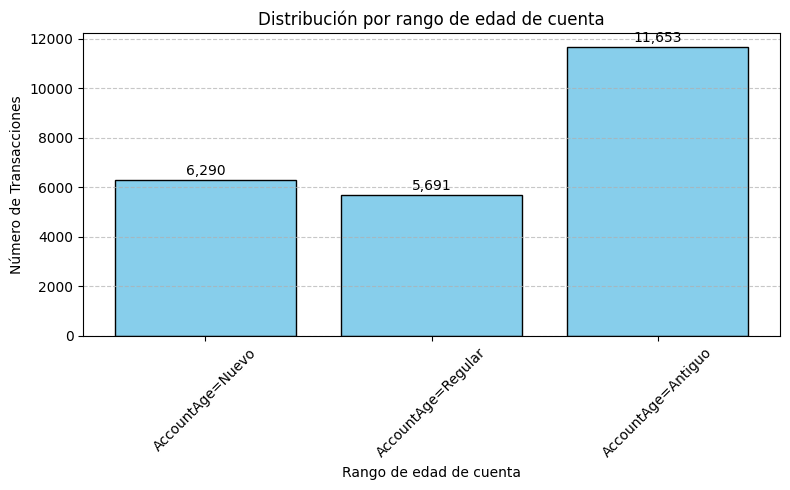

In [15]:
# Contar valores por categoría
age_account_counts = df['Account Age Binned'].value_counts().sort_index()

# Crear figura
plt.figure(figsize=(8, 5))
bars = plt.bar(age_account_counts.index, age_account_counts.values, color='skyblue', edgecolor='black')

# Añadir etiquetas encima de cada barra con separador de miles
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Etiquetas y formato
plt.title('Distribución por rango de edad de cuenta')
plt.xlabel('Rango de edad de cuenta')
plt.ylabel('Número de Transacciones')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 1.4. Transaction Hour:
Vamos a agrupar la hora en 4 bloques representativos del día:

| Rango de hora | Franja horaria | Etiqueta         |
| ------------- | -------------- | ---------------- |
| 0 – 5         | Madrugada      | `Hour=Madrugada` |
| 6 – 11        | Mañana         | `Hour=Mañana`    |
| 12 – 17       | Tarde          | `Hour=Tarde`     |
| 18 – 23       | Noche          | `Hour=Noche`     |


In [16]:
bins_hour = [-1, 5, 12, 17, 23]  # -1 para incluir 0 en el primer bin
labels_hour = ['Hour=Madrugada', 'Hour=Mañana', 'Hour=Tarde', 'Hour=Noche']

df['Transaction Hour Binned'] = pd.cut(df['Transaction Hour'], bins=bins_hour, labels=labels_hour)
df.iloc[:, list(range(n_cols)) + list(range(-1, 0))].head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Address Match,Transaction Hour Binned
0,42.32,PayPal,electronics,1,40,desktop,False,282,23,True,Hour=Noche
1,301.34,credit card,electronics,3,35,tablet,False,223,0,True,Hour=Madrugada
2,340.32,debit card,toys & games,5,29,desktop,False,360,8,False,Hour=Mañana
3,95.77,credit card,electronics,5,45,mobile,False,325,20,True,Hour=Noche
4,77.45,credit card,clothing,5,42,desktop,False,116,15,True,Hour=Tarde


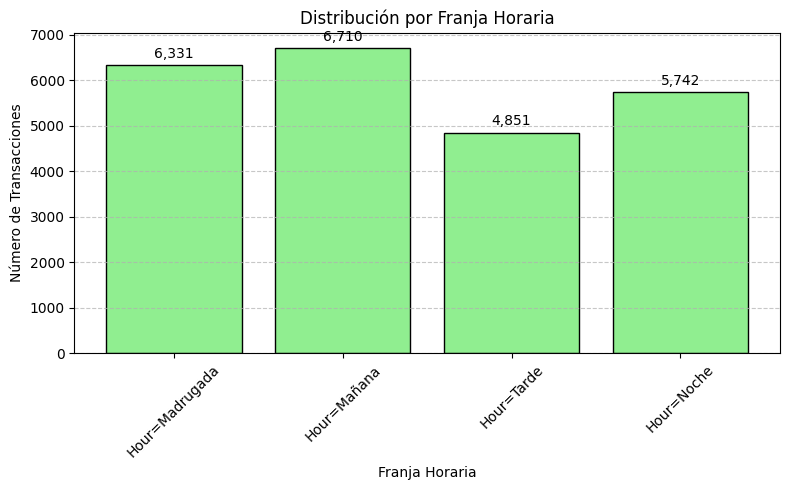

In [17]:
# Contar valores por categoría
hour_counts = df['Transaction Hour Binned'].value_counts().sort_index()

# Crear figura
plt.figure(figsize=(8, 5))
bars = plt.bar(hour_counts.index, hour_counts.values, color='lightgreen', edgecolor='black')

# Añadir etiquetas encima de cada barra con separador de miles
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Etiquetas y formato
plt.title('Distribución por Franja Horaria')
plt.xlabel('Franja Horaria')
plt.ylabel('Número de Transacciones')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 1.5. Transaction Day of Week
Vamos a agrupar la variable Transaction Day of Week en dos categorías: entre semana y fin de semana.

| Días de la semana      | Categoría     | Etiqueta              |
| ---------------------- | ------------- | --------------------- |
| Lunes a Jueves (0–3)  | Entre semana  | `Weekday=EntreSemana` |
| Viernes, Sábado y Domingo (4–6) | Fin de semana | `Weekday=FinDeSemana` |


In [18]:
def agrupar_dia_semana(dia):
    if dia in [0, 1, 2, 3]:
        return 'EntreSemana'
    else:
        return 'FinDeSemana'

df['Transaction Weekday Binned'] = df['Day of the week'].apply(agrupar_dia_semana)
df[['Transaction Weekday Binned', 'Day of the week']].head()

,Transaction Weekday Binned,Day of the week
0,FinDeSemana,6
1,EntreSemana,0
2,EntreSemana,0
3,EntreSemana,1
4,EntreSemana,1


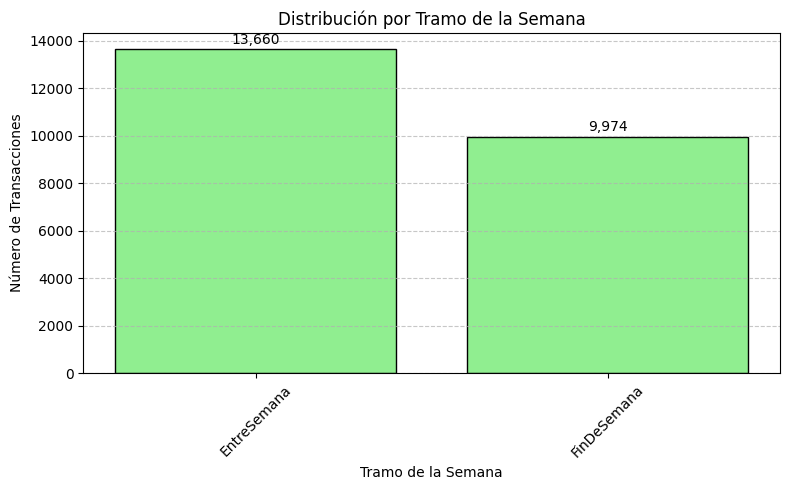

In [19]:
# Contar valores por categoría
weekday_counts = df['Transaction Weekday Binned'].value_counts().sort_index()

# Crear figura
plt.figure(figsize=(8, 5))
bars = plt.bar(weekday_counts.index, weekday_counts.values, color='lightgreen', edgecolor='black')

# Añadir etiquetas encima de cada barra con separador de miles
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Etiquetas y formato
plt.title('Distribución por Tramo de la Semana')
plt.xlabel('Tramo de la Semana')
plt.ylabel('Número de Transacciones')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##1.6. Transaction Month

In [20]:
# Mapeo de número a nombre de mes
meses = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo',
    4: 'Abril', 5: 'Mayo', 6: 'Junio',
    7: 'Julio', 8: 'Agosto', 9: 'Septiembre',
    10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}

# Crear la nueva columna
df['Transaction Month Binned'] = df['Month'].map(meses)

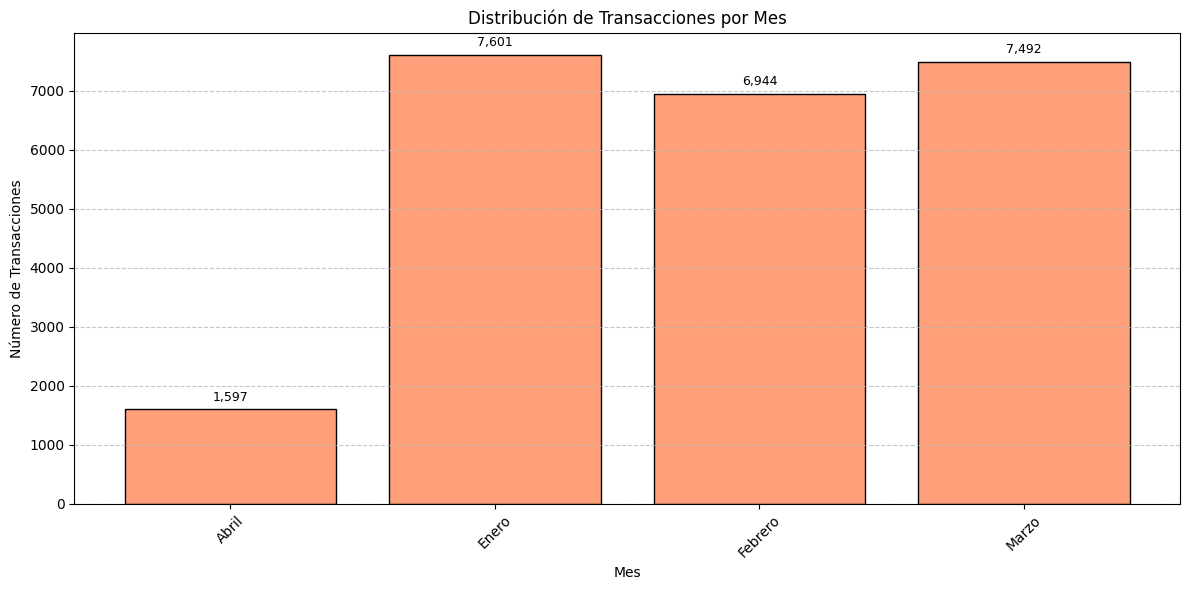

In [21]:
# Contar valores por categoría
month_counts = df['Transaction Month Binned'].value_counts().sort_index()

# Crear figura
plt.figure(figsize=(12, 6))
bars = plt.bar(month_counts.index, month_counts.values, color='lightsalmon', edgecolor='black')

# Añadir etiquetas encima de cada barra con separador de miles
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# Etiquetas y formato
plt.title('Distribución de Transacciones por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Transacciones')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 1.7. Quantity

Para la variable cantidad, la segmentaremos en 3 categorías: Una, pocas o varias unidades compradas en la misma transacción.

| Rango   | Etiqueta          |
| ------- | ----------------- |
| 1       | `Quantity=Una`    |
| 2–3     | `Quantity=Pocas`  |
| 4 o más | `Quantity=Varias` |

In [22]:
def categorizar_quantity(q):
    if q == 1:
        return 'Quantity=Una'
    elif q in [2, 3]:
        return 'Quantity=Pocas'
    else:
        return 'Quantity=Varias'

df['Quantity Binned'] = df['Quantity'].apply(categorizar_quantity)

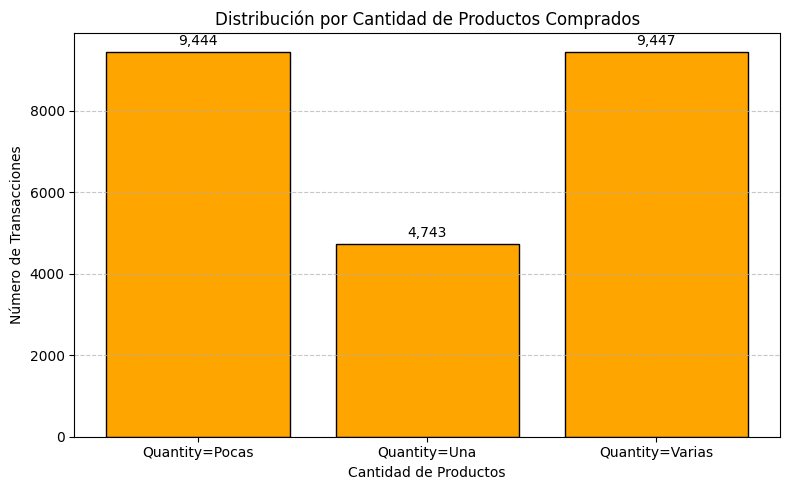

In [23]:
# Contar valores por categoría
quantity_counts = df['Quantity Binned'].value_counts().sort_index()

# Crear figura
plt.figure(figsize=(8, 5))
bars = plt.bar(quantity_counts.index, quantity_counts.values, color='orange', edgecolor='black')

# Añadir etiquetas encima de cada barra con separador de miles
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Etiquetas y formato
plt.title('Distribución por Cantidad de Productos Comprados')
plt.xlabel('Cantidad de Productos')
plt.ylabel('Número de Transacciones')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 1.8. Address Match

Esta variable se podría utilizar como se encuentra, pero para un mayor entendimiento de las reglas de asociación, la transforaremos a cadenas textuales con mayor facilidad de interpretación.

| Valor original | Nueva etiqueta    |
| -------------- | ----------------- |
| `True`         | `AddressMatch=Sí` |
| `False`        | `AddressMatch=No` |


In [25]:
df['Address Match Binned'] = df['Address Match'].map({True: 'AddressMatch=Sí', False: 'AddressMatch=No'})
df[['Address Match', 'Address Match Binned']].head(10)

,Address Match,Address Match Binned
0,True,AddressMatch=Sí
1,True,AddressMatch=Sí
2,False,AddressMatch=No
3,True,AddressMatch=Sí
4,True,AddressMatch=Sí
5,True,AddressMatch=Sí
6,True,AddressMatch=Sí
7,True,AddressMatch=Sí
8,True,AddressMatch=Sí
9,True,AddressMatch=Sí


## 1.9. Device Used
Es necesario modificar la etiqueta por el mismo motivo de la variable 'Address Match' y porque, para alguien sin contexto sobre los datos, podría haber confusión entre 'Device Used' y 'Product Category'.

| Valor original | Nueva etiqueta   |
| -------------- | ---------------- |
| `Mobile`       | `Device=Mobile`  |
| `Desktop`      | `Device=Desktop` |
| `Tablet`       | `Device=Tablet`  |


In [26]:
df['Device Used Binned'] = df['Device Used'].apply(lambda x: f'Device={x}')
df[['Device Used', 'Device Used Binned']].head(10)

,Device Used,Device Used Binned
0,desktop,Device=desktop
1,tablet,Device=tablet
2,desktop,Device=desktop
3,mobile,Device=mobile
4,desktop,Device=desktop
5,desktop,Device=desktop
6,mobile,Device=mobile
7,tablet,Device=tablet
8,mobile,Device=mobile
9,mobile,Device=mobile


## 1.10. Product Category

Se renombrarán las categorías de la siguiente manera:


| Valor original      | Etiqueta transformada        |
| ------------------- | ---------------------------- |
| `Electronics`       | `Category=Electronics`       |
| `Clothing`          | `Category=Clothing`          |
| `Home & Garden`     | `Category=HomeandGarden`     |
| `Health & Beauty`   | `Category=HealthandBeauty`   |
| `Sports & Outdoors` | `Category=SportsandOutdoors` |



In [27]:
def etiquetar_categoria(categoria):
    # Quitar espacios, reemplazar "&" por "and", quitar caracteres problemáticos si los hay
    categoria_formateada = categoria.strip().replace("&", "and").replace(" ", "")
    return f'Category={categoria_formateada}'

df['Product Category Binned'] = df['Product Category'].apply(etiquetar_categoria)

df[['Product Category', 'Product Category Binned']].head(10)

,Product Category,Product Category Binned
0,electronics,Category=electronics
1,electronics,Category=electronics
2,toys & games,Category=toysandgames
3,electronics,Category=electronics
4,clothing,Category=clothing
5,toys & games,Category=toysandgames
6,toys & games,Category=toysandgames
7,electronics,Category=electronics
8,home & garden,Category=homeandgarden
9,toys & games,Category=toysandgames


In [28]:
df['Product Category Binned'].unique()

array(['Category=electronics', 'Category=toysandgames',
       'Category=clothing', 'Category=homeandgarden',
       'Category=healthandbeauty'], dtype=object)

## 1.11. Payment Method.

Renombraremos también la columna de Payment Method.

| Valor original | Etiqueta transformada |
| -------------- | --------------------- |
| `Credit Card`  | `Payment=CreditCard`  |
| `PayPal`       | `Payment=PayPal`      |
| `Bitcoin`      | `Payment=Bitcoin`     |
| `Debit Card`   | `Payment=DebitCard`   |
| `Apple Pay`    | `Payment=ApplePay`    |


In [29]:
def etiquetar_pago(metodo):
    return f"Payment={metodo.strip().replace(' ', '')}"

df['Payment Method Binned'] = df['Payment Method'].apply(etiquetar_pago)
df[['Payment Method', 'Payment Method Binned']].head(10)

,Payment Method,Payment Method Binned
0,PayPal,Payment=PayPal
1,credit card,Payment=creditcard
2,debit card,Payment=debitcard
3,credit card,Payment=creditcard
4,credit card,Payment=creditcard
5,PayPal,Payment=PayPal
6,debit card,Payment=debitcard
7,debit card,Payment=debitcard
8,debit card,Payment=debitcard
9,bank transfer,Payment=banktransfer


## 1.12. Is Fraud

Por último, dado que nuestra etiqueta objetivo es actualmente booleana, vamos a transformarla a 'Fraude' y 'Legitima'

| Valor original | Nueva etiqueta   |
| -------------- | ---------------- |
| `1`            | `Clase=Fraude`   |
| `0`            | `Clase=Legítima` |


In [30]:
df['Is Fraudulent'].value_counts()

,count
Is Fraudulent,
False,22412
True,1222


In [31]:
def etiquetar_fraude(valor):
    if valor == 1:
        return 'Clase=Fraude'
    else:
        return 'Clase=Legítima'

def etiquetar_fraude(valor):
    if valor == 1:
        return 'Clase=Fraude'
    else:
        return 'Clase=Legítima'

df['Is Fraudulent Binned'] = df['Is Fraudulent'].apply(etiquetar_fraude)
df['Is Fraudulent Binned'].value_counts()

,count
Is Fraudulent Binned,
Clase=Legítima,22412
Clase=Fraude,1222


## 1.11 Dropear columnas que no serán utilizadas o que ya fueron transformadas.


In [32]:
df.columns

Index(['Transaction Amount', 'Payment Method', 'Product Category', 'Quantity',
       'Customer Age', 'Device Used', 'Is Fraudulent', 'Account Age Days',
       'Transaction Hour', 'Address Match', 'Day', 'Day of the week', 'Month',
       'Transaction Amount Binned', 'Customer Age Binned',
       'Account Age Binned', 'Transaction Hour Binned',
       'Transaction Weekday Binned', 'Transaction Month Binned',
       'Quantity Binned', 'Address Match Binned', 'Device Used Binned',
       'Product Category Binned', 'Payment Method Binned',
       'Is Fraudulent Binned'],
      dtype='object')

In [33]:
df_asociacion = df.copy()

In [34]:
columnas_a_eliminar = [
    'Is Fraudulent','Transaction Amount', 'Payment Method', 'Product Category', 'Quantity',
    'Customer Age', 'Device Used', 'Account Age Days', 'Transaction Hour',
    'Address Match', 'Day', 'Day of the week', 'Month'
]

df_asociacion.drop(columns=columnas_a_eliminar, inplace=True)
df_asociacion.head()

,Transaction Amount Binned,Customer Age Binned,Account Age Binned,Transaction Hour Binned,Transaction Weekday Binned,Transaction Month Binned,Quantity Binned,Address Match Binned,Device Used Binned,Product Category Binned,Payment Method Binned,Is Fraudulent Binned
0,Amount=Bajo,Age=AdultoJoven,AccountAge=Antiguo,Hour=Noche,FinDeSemana,Marzo,Quantity=Una,AddressMatch=Sí,Device=desktop,Category=electronics,Payment=PayPal,Clase=Legítima
1,Amount=Muy Alto,Age=AdultoJoven,AccountAge=Antiguo,Hour=Madrugada,EntreSemana,Enero,Quantity=Pocas,AddressMatch=Sí,Device=tablet,Category=electronics,Payment=creditcard,Clase=Legítima
2,Amount=Muy Alto,Age=AdultoJoven,AccountAge=Antiguo,Hour=Mañana,EntreSemana,Enero,Quantity=Varias,AddressMatch=No,Device=desktop,Category=toysandgames,Payment=debitcard,Clase=Legítima
3,Amount=Medio,Age=Adulto,AccountAge=Antiguo,Hour=Noche,EntreSemana,Enero,Quantity=Varias,AddressMatch=Sí,Device=mobile,Category=electronics,Payment=creditcard,Clase=Legítima
4,Amount=Medio,Age=Adulto,AccountAge=Regular,Hour=Tarde,EntreSemana,Enero,Quantity=Varias,AddressMatch=Sí,Device=desktop,Category=clothing,Payment=creditcard,Clase=Legítima


In [35]:
df_asociacion.columns

Index(['Transaction Amount Binned', 'Customer Age Binned',
       'Account Age Binned', 'Transaction Hour Binned',
       'Transaction Weekday Binned', 'Transaction Month Binned',
       'Quantity Binned', 'Address Match Binned', 'Device Used Binned',
       'Product Category Binned', 'Payment Method Binned',
       'Is Fraudulent Binned'],
      dtype='object')

Como resumen del preprocesamiento realizado, tenemos:

| Variable original    | Transformación realizada                     | Nueva columna creada         | Formato final ejemplo                    |
| -------------------- | -------------------------------------------- | ---------------------------- | ---------------------------------------- |
| `Transaction Amount` | Discretización por percentiles (cuartiles)   | `Transaction Amount Binned`  | `Amount=Bajo`, `Amount=Muy Alto`         |
| `Customer Age`       | Discretización semántica por rangos de edad  | `Customer Age Binned`        | `Age=Joven`, `Age=AdultoMayor`           |
| `Account Age Days`   | Discretización en 3 categorías de antigüedad | `Account Age Binned`         | `AccountAge=Nuevo`, `AccountAge=Antiguo` |
| `Transaction Hour`   | Agrupación por franjas horarias              | `Transaction Hour Binned`    | `Hour=Mañana`, `Hour=Noche`              |
| `Day of the week`    | Agrupación en entre semana y fin de semana   | `Transaction Weekday Binned` | `Weekday=EntreSemana`                    |
| `Month`              | Mapeo a nombre del mes                       | `Transaction Month Binned`   | `Month=Enero`, `Month=Diciembre`         |
| `Quantity`           | Agrupación semántica                         | `Quantity Binned`            | `Quantity=Una`, `Quantity=Varias`        |
| `Address Match`      | Conversión booleana a etiqueta legible       | `Address Match Binned`       | `AddressMatch=Sí`, `AddressMatch=No`     |
| `Device Used`        | Mapeo directo con prefijo                    | `Device Used Binned`         | `Device=Mobile`                          |
| `Product Category`   | Limpieza de texto + prefijo                  | `Product Category Binned`    | `Category=HealthandBeauty`               |
| `Payment Method`     | Limpieza de texto + prefijo                  | `Payment Method Binned`      | `Payment=CreditCard`                     |
| `Is Fraudulent`      | Etiquetado semántico binario                 | `Is Fraudulent Binned`       | `Clase=Fraude`, `Clase=Legítima`         |


### Descarga CSV

In [36]:
df_asociacion.to_csv('df_asociacion.csv', index=False)

#2.FP-Growth

In [36]:
df_asociacion = pd.read_csv('df_asociacion.csv')
df_asociacion.head()

,Transaction Amount Binned,Customer Age Binned,Account Age Binned,Transaction Hour Binned,Transaction Weekday Binned,Transaction Month Binned,Quantity Binned,Address Match Binned,Device Used Binned,Product Category Binned,Payment Method Binned,Is Fraudulent Binned
0,Amount=Bajo,Age=AdultoJoven,AccountAge=Antiguo,Hour=Noche,FinDeSemana,Marzo,Quantity=Una,AddressMatch=Sí,Device=desktop,Category=electronics,Payment=PayPal,Clase=Legítima
1,Amount=Muy Alto,Age=AdultoJoven,AccountAge=Antiguo,Hour=Madrugada,EntreSemana,Enero,Quantity=Pocas,AddressMatch=Sí,Device=tablet,Category=electronics,Payment=creditcard,Clase=Legítima
2,Amount=Muy Alto,Age=AdultoJoven,AccountAge=Antiguo,Hour=Mañana,EntreSemana,Enero,Quantity=Varias,AddressMatch=No,Device=desktop,Category=toysandgames,Payment=debitcard,Clase=Legítima
3,Amount=Medio,Age=Adulto,AccountAge=Antiguo,Hour=Noche,EntreSemana,Enero,Quantity=Varias,AddressMatch=Sí,Device=mobile,Category=electronics,Payment=creditcard,Clase=Legítima
4,Amount=Medio,Age=Adulto,AccountAge=Regular,Hour=Tarde,EntreSemana,Enero,Quantity=Varias,AddressMatch=Sí,Device=desktop,Category=clothing,Payment=creditcard,Clase=Legítima


In [37]:
df_asociacion.shape

(23634, 12)

Ahora, lo primero que debemos hacer es convertir nuestra df a formato de transacciones (listas) para poder aplicar el algoritmo.

In [38]:
from mlxtend.preprocessing import TransactionEncoder

# Convertir filas a listas de items (formato de transacciones)
transacciones = df_asociacion.values.tolist()

# Aplicar TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transacciones).transform(transacciones)

# Crear DataFrame binarizado
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

 También, se realiza la conversión a one-hot encoding ya que es la entrada que que espera recibir fpgrowth de mxlextend.

 Con esto, aplicamos fpgrowth para construir los conjuntos de items frecuentes y las reglas de asociación.

In [56]:
from mlxtend.frequent_patterns import fpgrowth
import time

start = time.time()

# Calcular itemsets frecuentes
itemsets = fpgrowth(df_onehot, min_support=0.1, use_colnames=True)

end = time.time()

itemsets.sort_values('support', ascending=False).head()

,support,itemsets
0,0.948295,(Clase=Legítima)
1,0.900905,(AddressMatch=Sí)
36,0.854489,"(AddressMatch=Sí, Clase=Legítima)"
12,0.577981,(EntreSemana)
2,0.560421,(Age=AdultoJoven)


In [120]:
from mlxtend.frequent_patterns import association_rules

# Generar reglas
reglas = association_rules(itemsets, metric='confidence', min_threshold=0.95)
reglas_fp = reglas_apriori  = reglas[['antecedents', 'consequents', 'antecedent support','consequent support', 'support', 'confidence', 'lift']]

In [121]:
reglas_fp.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
143,"(Hour=Tarde, AccountAge=Antiguo)",(Clase=Legítima),0.102649,0.948295,0.101168,0.985573,1.039311
44,"(AccountAge=Antiguo, Hour=Noche)",(Clase=Legítima),0.121647,0.948295,0.119447,0.981913,1.035451
31,"(Amount=Bajo, AccountAge=Antiguo)",(Clase=Legítima),0.125878,0.948295,0.123509,0.981176,1.034674
45,"(AccountAge=Antiguo, AddressMatch=Sí, Hour=Noche)",(Clase=Legítima),0.110138,0.948295,0.108065,0.981176,1.034674
98,"(AccountAge=Antiguo, Hour=Mañana)",(Clase=Legítima),0.140349,0.948295,0.137556,0.980103,1.033542


In [67]:
# Opcional: filtrar reglas cuyo consecuente es fraude
reglas_fraude = reglas[reglas['consequents'].astype(str).str.contains('Clase=Fraude')]

reglas_fraude.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


# 3.Apriori

In [97]:
from mlxtend.frequent_patterns import apriori

# Calcular itemsets frecuentes con soporte mínimo
itemsets_apriori = apriori(df_onehot, min_support=0.05, use_colnames=True)

In [98]:
# Ordenar por soporte
itemsets_apriori.sort_values(by='support', ascending=False).head()

,support,itemsets
19,0.948295,(Clase=Legítima)
5,0.900905,(AddressMatch=Sí)
148,0.854489,"(AddressMatch=Sí, Clase=Legítima)"
24,0.577981,(EntreSemana)
7,0.560421,(Age=AdultoJoven)


In [117]:
from mlxtend.frequent_patterns import association_rules

# Generar reglas a partir de los itemsets
reglas_apriori = association_rules(itemsets_apriori, metric="confidence", min_threshold=0.95)

In [118]:
reglas_apriori.shape

(773, 14)

In [119]:
# Generar las reglas con alto umbral de confianza
reglas_apriori = association_rules(itemsets_apriori, metric="confidence", min_threshold=0.95)

# Filtrar solo las columnas deseadas
reglas_apriori  = reglas_apriori[['antecedents', 'consequents', 'antecedent support','consequent support', 'support', 'confidence', 'lift']]
reglas_apriori.sort_values(by='lift', ascending=False).head().round(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
689,"(AccountAge=Antiguo, EntreSemana, AddressMatch...",(Clase=Legítima),0.054,0.948,0.053,0.989,1.043
346,"(EntreSemana, AccountAge=Antiguo, Hour=Tarde)",(Clase=Legítima),0.060,0.948,0.059,0.988,1.042
274,"(AccountAge=Antiguo, Hour=Tarde, AddressMatch=Sí)",(Clase=Legítima),0.092,0.948,0.091,0.986,1.040
37,"(Hour=Tarde, AccountAge=Antiguo)",(Clase=Legítima),0.103,0.948,0.101,0.986,1.039
304,"(Hour=Tarde, AccountAge=Antiguo, Age=AdultoJoven)",(Clase=Legítima),0.058,0.948,0.057,0.985,1.039


In [112]:
reglas_apriori.sort_values(by='lift', ascending=False).tail().round(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
103,"(Quantity=Pocas, Age=AdultoJoven)",(Clase=Legítima),0.225,0.948,0.213,0.95,1.002
590,"(Quantity=Pocas, Enero, Age=AdultoJoven)",(Clase=Legítima),0.073,0.948,0.069,0.95,1.002
555,"(Marzo, Quantity=Pocas, AddressMatch=Sí)",(Clase=Legítima),0.114,0.948,0.109,0.95,1.002
192,"(EntreSemana, Device=tablet)",(Clase=Legítima),0.191,0.948,0.182,0.95,1.002
730,"(Quantity=Pocas, Enero, AddressMatch=Sí, Age=A...",(Clase=Legítima),0.066,0.948,0.063,0.95,1.002


In [114]:
# filtrar las reglas donde el consecuente sea Clase=Fraude
reglas_fraude = reglas_apriori[reglas_apriori['consequents'].astype(str).str.contains("Clase=Fraude")]

# Ver las reglas ordenadas por lift
reglas_fraude.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift


In [123]:
!pip install xlsxwriter
with pd.ExcelWriter("reglas_asociacion.xlsx", engine='xlsxwriter') as writer:
    reglas_apriori.to_excel(writer, sheet_name="Apriori", index=False)
    reglas_fp.to_excel(writer, sheet_name="FP-Growth", index=False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 10.7 MB/s eta 0:00:00


#4.Submuestreo con oversampling de la clase minoritaria

Dado que las reglas obtenidas tienen un lift muy cercano a uno y no incluyen registros con consecuentes de fraude, se realiza una submuestreo, en donde se incluye mayor cantidad de casos para balancear un poco la muestra.

In [39]:
# Separar clases
df_fraude = df_asociacion[df_asociacion['Is Fraudulent Binned'] == 'Clase=Fraude']
df_legitima = df_asociacion[df_asociacion['Is Fraudulent Binned'] == 'Clase=Legítima']

# Submuestreo de clase mayoritaria
df_legitima_muestra = df_legitima.sample(n=len(df_fraude)*3, random_state=42)  # relación 1:3

# Combinar
df_balanceado = pd.concat([df_fraude, df_legitima_muestra])

In [40]:
df_balanceado['Is Fraudulent Binned'].value_counts()

,count
Is Fraudulent Binned,
Clase=Legítima,3666
Clase=Fraude,1222


##4.1. FP-Growth

In [80]:
from mlxtend.preprocessing import TransactionEncoder

# Convertir filas a listas de items (formato de transacciones)
transacciones_bal = df_balanceado.values.tolist()

# Aplicar TransactionEncoder
te_bal = TransactionEncoder()
te_ary_bal = te_bal.fit(transacciones_bal).transform(transacciones_bal)

# Crear DataFrame binarizado
df_onehot_bal = pd.DataFrame(te_ary_bal, columns=te_bal.columns_)

In [86]:
from mlxtend.frequent_patterns import fpgrowth
import time

# Calcular itemsets frecuentes
itemsets = fpgrowth(df_onehot_bal, min_support=0.05, use_colnames=True)

itemsets.sort_values('support', ascending=False).head()

,support,itemsets
0,0.899550,(AddressMatch=Sí)
38,0.750000,(Clase=Legítima)
2303,0.675123,"(Clase=Legítima, AddressMatch=Sí)"
1,0.565466,(EntreSemana)
12,0.551759,(Age=AdultoJoven)


In [87]:
from mlxtend.frequent_patterns import association_rules

# Generar reglas
reglas_fp_2 = association_rules(itemsets, metric='confidence', min_threshold=0.4)
reglas_fp_bal = reglas_fp_2[['antecedents', 'consequents', 'antecedent support','consequent support', 'support', 'confidence', 'lift']]

In [88]:
reglas_fp_bal.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
1238,"(AccountAge=Nuevo, Hour=Madrugada)",(Clase=Fraude),0.126432,0.250000,0.078969,0.624595,2.498382
1245,"(AccountAge=Nuevo, Hour=Madrugada)","(Clase=Fraude, AddressMatch=Sí)",0.126432,0.224427,0.070581,0.558252,2.487455
1242,"(AddressMatch=Sí, AccountAge=Nuevo, Hour=Madru...",(Clase=Fraude),0.114157,0.250000,0.070581,0.618280,2.473118
1172,"(Amount=Muy Alto, Hour=Madrugada)",(Clase=Fraude),0.110884,0.250000,0.064444,0.581181,2.324723
1187,"(AddressMatch=Sí, Amount=Muy Alto, Hour=Madrug...",(Clase=Fraude),0.099427,0.250000,0.057079,0.574074,2.296296


In [89]:
# Opcional: filtrar reglas cuyo consecuente es fraude
reglas_fraude_fp = reglas_fp_bal[reglas_fp_bal['consequents'].astype(str).str.contains('Clase=Fraude')]
reglas_fraude_fp.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
1238,"(AccountAge=Nuevo, Hour=Madrugada)",(Clase=Fraude),0.126432,0.250000,0.078969,0.624595,2.498382
1245,"(AccountAge=Nuevo, Hour=Madrugada)","(Clase=Fraude, AddressMatch=Sí)",0.126432,0.224427,0.070581,0.558252,2.487455
1242,"(AddressMatch=Sí, AccountAge=Nuevo, Hour=Madru...",(Clase=Fraude),0.114157,0.250000,0.070581,0.618280,2.473118
1172,"(Amount=Muy Alto, Hour=Madrugada)",(Clase=Fraude),0.110884,0.250000,0.064444,0.581181,2.324723
1187,"(AddressMatch=Sí, Amount=Muy Alto, Hour=Madrug...",(Clase=Fraude),0.099427,0.250000,0.057079,0.574074,2.296296


## 4.2. Apriori

In [95]:
from mlxtend.frequent_patterns import apriori

# Calcular itemsets frecuentes con soporte mínimo
itemsets_apriori_bal = apriori(df_onehot_bal, min_support=0.05, use_colnames=True)

In [96]:
# Generar reglas a partir de los itemsets
reglas_apriori_bal = association_rules(itemsets_apriori_bal, metric="confidence", min_threshold=0.4)
reglas_apriori_bal = reglas_apriori_bal[['antecedents', 'consequents', 'antecedent support','consequent support', 'support', 'confidence', 'lift']]

In [97]:
reglas_apriori_bal.sort_values(by='lift', ascending=False).head().round(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
650,"(AccountAge=Nuevo, Hour=Madrugada)",(Clase=Fraude),0.126,0.250,0.079,0.625,2.498
2798,"(AccountAge=Nuevo, Hour=Madrugada)","(Clase=Fraude, AddressMatch=Sí)",0.126,0.224,0.071,0.558,2.487
2795,"(AddressMatch=Sí, AccountAge=Nuevo, Hour=Madru...",(Clase=Fraude),0.114,0.250,0.071,0.618,2.473
1702,"(Amount=Muy Alto, Hour=Madrugada)",(Clase=Fraude),0.111,0.250,0.064,0.581,2.325
3617,"(AddressMatch=Sí, Amount=Muy Alto, Hour=Madrug...",(Clase=Fraude),0.099,0.250,0.057,0.574,2.296


In [98]:
# filtrar las reglas donde el consecuente sea Clase=Fraude
reglas_fraude_apriori = reglas_apriori_bal[reglas_apriori_bal['consequents'].astype(str).str.contains("Clase=Fraude")]

# Ver las reglas ordenadas por lift
reglas_fraude_apriori.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
650,"(AccountAge=Nuevo, Hour=Madrugada)",(Clase=Fraude),0.126432,0.250000,0.078969,0.624595,2.498382
2798,"(AccountAge=Nuevo, Hour=Madrugada)","(Clase=Fraude, AddressMatch=Sí)",0.126432,0.224427,0.070581,0.558252,2.487455
2795,"(AddressMatch=Sí, AccountAge=Nuevo, Hour=Madru...",(Clase=Fraude),0.114157,0.250000,0.070581,0.618280,2.473118
1702,"(Amount=Muy Alto, Hour=Madrugada)",(Clase=Fraude),0.110884,0.250000,0.064444,0.581181,2.324723
3617,"(AddressMatch=Sí, Amount=Muy Alto, Hour=Madrug...",(Clase=Fraude),0.099427,0.250000,0.057079,0.574074,2.296296


In [ ]:
!pip install xlsxwriter

In [99]:
with pd.ExcelWriter("reglas_asociacion_bal.xlsx", engine='xlsxwriter') as writer:
    reglas_apriori_bal.to_excel(writer, sheet_name="Apriori", index=False)
    reglas_fp_bal.to_excel(writer, sheet_name="FP-Growth", index=False)
    reglas_fraude_apriori.to_excel(writer, sheet_name="Apriori_Fraude", index=False)
    reglas_fraude_fp.to_excel(writer, sheet_name="FP-Growth_Fraude", index=False)